Especialização em Ciência dos Dados – Redes Neurais Artificiais (Aprendizado Profundo/Deep Learning)

2º Desafio em Deep Learning

Aluna: Cristiane Gea

In [1]:
# ==========================
# IMPORTAÇÕES E LEITURA BASE
# ==========================

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

In [2]:
# ========
# PIPELINE
# ========

# 1) Ler a base
print("Carregando base de dados...")
df = pd.read_excel("BaseDados_DEC.xlsx")

# Selecionar variáveis
X = df.loc[:, "AREA":"ENE_PNI"]
y = df["DEC_MED"]

print(f"Dimensões: X {X.shape}, y {y.shape}")

# 2) Imputar valores faltantes (mediana)
print("Imputando valores faltantes...")
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)
y_imputed = imputer.fit_transform(y.values.reshape(-1, 1)).ravel()

# 3) Escalar variáveis
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

Carregando base de dados...
Dimensões: X (2540, 133), y (2540,)
Imputando valores faltantes...


In [3]:
# ==========================
# FUNÇÕES AUXILIARES
# ==========================

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def comprehensive_evaluation(y_true, y_pred, model_name):
    """Avaliação completa do modelo"""
    rmse_val = rmse(y_true, y_pred)
    mae_val = mean_absolute_error(y_true, y_pred)
    r2_val = r2_score(y_true, y_pred)

    return {
        'Modelo': model_name,
        'RMSE': rmse_val,
        'MAE': mae_val,
        'R²': r2_val,
        'RMSE_%': (rmse_val / np.mean(y_true)) * 100,
        'MAE_%': (mae_val / np.mean(y_true)) * 100
    }

def plot_residuals(y_true, y_pred, model_name, ax):
    """Plot de resíduos"""
    residuals = y_true - y_pred
    ax.scatter(y_pred, residuals, alpha=0.6)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Valores Preditos')
    ax.set_ylabel('Resíduos')
    ax.set_title(f'Resíduos - {model_name}')

    # Adicionar estatísticas no gráfico
    textstr = f'Mean: {residuals.mean():.3f}\nStd: {residuals.std():.3f}'
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

def plot_qq_residuals(y_true, y_pred, model_name, ax):
    """Plot Q-Q para normalidade dos resíduos"""
    residuals = y_true - y_pred
    stats.probplot(residuals, dist="norm", plot=ax)
    ax.set_title(f'Q-Q Plot - {model_name}')

In [4]:
# ==========================
# VALIDAÇÃO CRUZADA
# ==========================

print("Iniciando validação cruzada...")
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Arrays para armazenar previsões
y_pred_lin = np.zeros_like(y_imputed, dtype=float)
y_pred_rf = np.zeros_like(y_imputed, dtype=float)
y_pred_nn = np.zeros_like(y_imputed, dtype=float)

# Aplicar transformação logarítmica para regressão linear
y_log = np.log(y_imputed + 1e-8)  # pequeno epsilon para evitar log(0)

Iniciando validação cruzada...


In [5]:
# ==========================
# MODELAGEM
# ==========================

# 1) REGRESSÃO LINEAR (com transformação log)
print("Treinando Regressão Linear...")
linreg = LinearRegression()
y_pred_lin_log = cross_val_predict(linreg, X_scaled, y_log, cv=kf)
y_pred_lin = np.exp(y_pred_lin_log)  # Voltar para escala original

# 2) RANDOM FOREST
print("Treinando Random Forest...")
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    max_depth=20,
    min_samples_split=5
)
y_pred_rf = cross_val_predict(rf, X_imputed, y_imputed, cv=kf)

# 3) REDE NEURAL
print("Treinando Rede Neural...")
for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled)):
    print(f"  Fold {fold + 1}/5")

    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y_imputed[train_idx], y_imputed[test_idx]

    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1)
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    early_stop = keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=15,
        restore_best_weights=True,
        verbose=0
    )

    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=32,
        verbose=0,
        callbacks=[early_stop]
    )

    y_pred_nn[test_idx] = model.predict(X_test, verbose=0).flatten()

Treinando Regressão Linear...
Treinando Random Forest...
Treinando Rede Neural...
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5


In [6]:
# ==========================
# AVALIAÇÃO DOS MODELOS
# ==========================

print("\n" + "="*50)
print("AVALIAÇÃO DOS MODELOS")
print("="*50)

# Métricas completas
models_predictions = {
    'Regressão Linear (log)': y_pred_lin,
    'Random Forest': y_pred_rf,
    'Rede Neural': y_pred_nn
}

metrics_results = []
for name, preds in models_predictions.items():
    metrics = comprehensive_evaluation(y_imputed, preds, name)
    metrics_results.append(metrics)
    print(f"\n{name}:")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  MAE: {metrics['MAE']:.4f}")
    print(f"  R²: {metrics['R²']:.4f}")
    print(f"  RMSE (% média): {metrics['RMSE_%']:.2f}%")

# DataFrame com resultados
results_df = pd.DataFrame(metrics_results)
print("\n" + "="*50)
print("TABELA COMPARATIVA")
print("="*50)
print(results_df.round(4))


AVALIAÇÃO DOS MODELOS

Regressão Linear (log):
  RMSE: 32.2930
  MAE: 9.8735
  R²: 0.4171
  RMSE (% média): 134.06%

Random Forest:
  RMSE: 21.3036
  MAE: 8.3189
  R²: 0.7463
  RMSE (% média): 88.44%

Rede Neural:
  RMSE: 18.4792
  MAE: 7.9534
  R²: 0.8091
  RMSE (% média): 76.71%

TABELA COMPARATIVA
                   Modelo     RMSE     MAE      R²    RMSE_%    MAE_%
0  Regressão Linear (log)  32.2930  9.8735  0.4171  134.0603  40.9887
1           Random Forest  21.3036  8.3189  0.7463   88.4392  34.5347
2             Rede Neural  18.4792  7.9534  0.8091   76.7138  33.0177



Gerando gráficos...


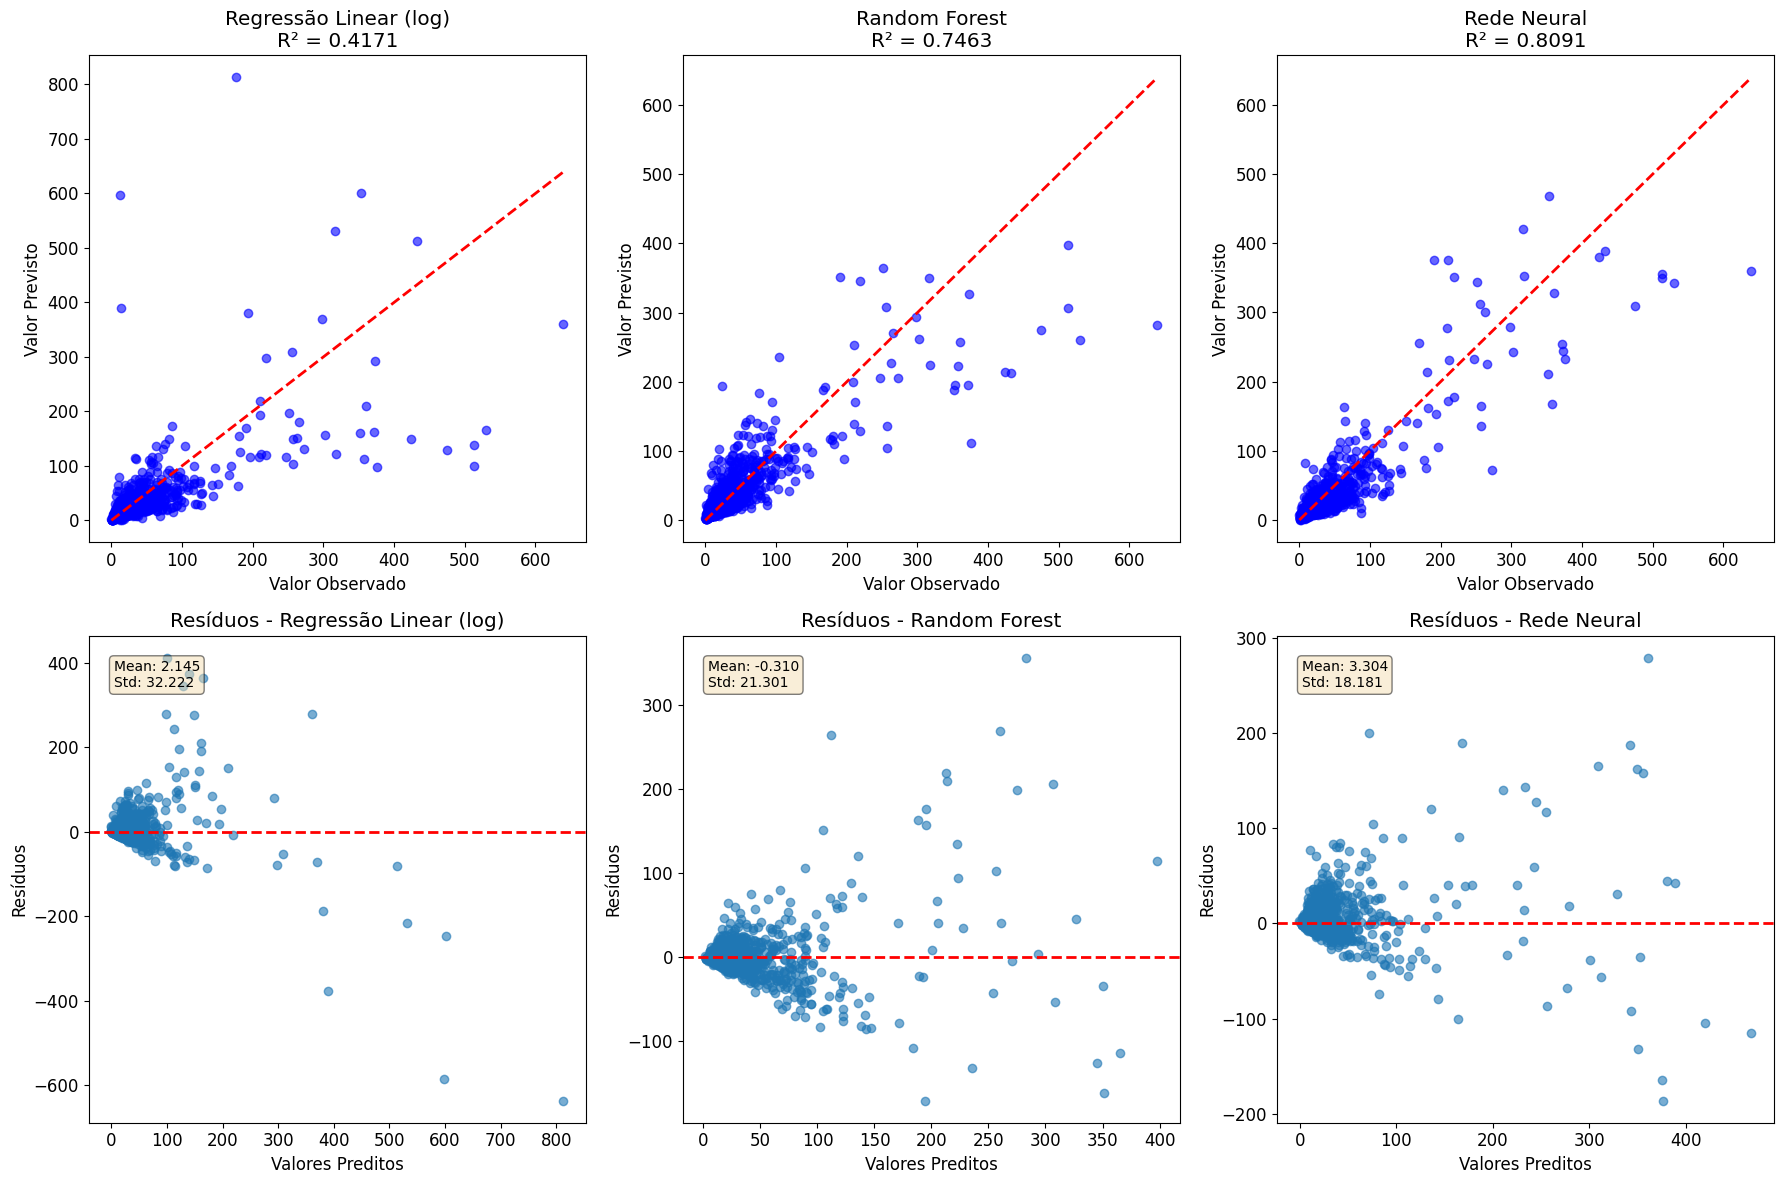

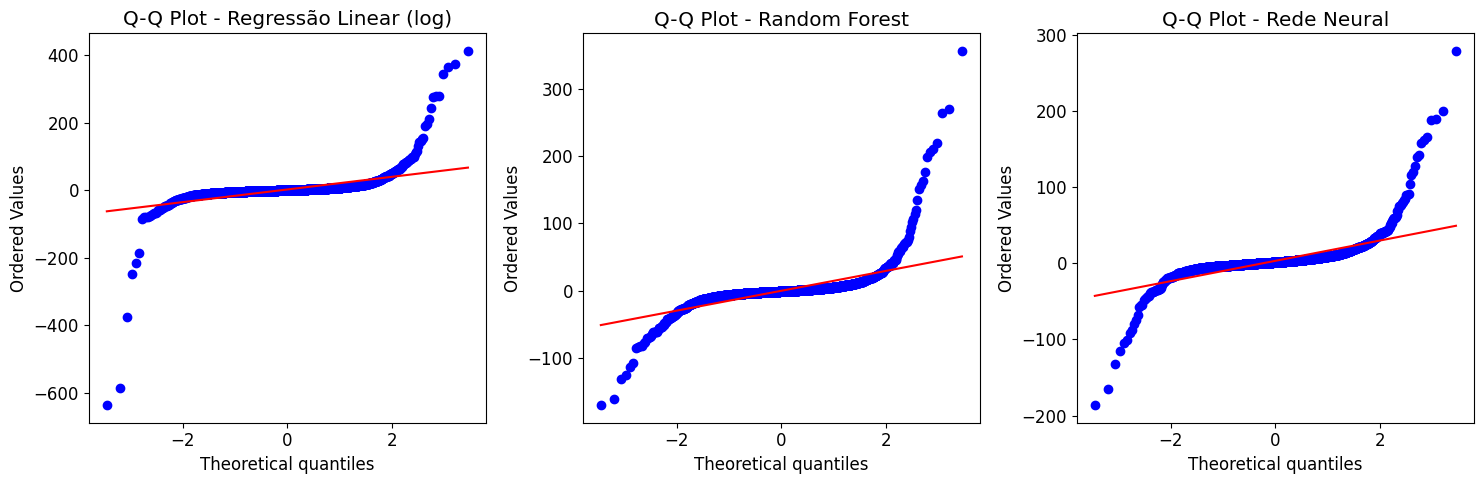

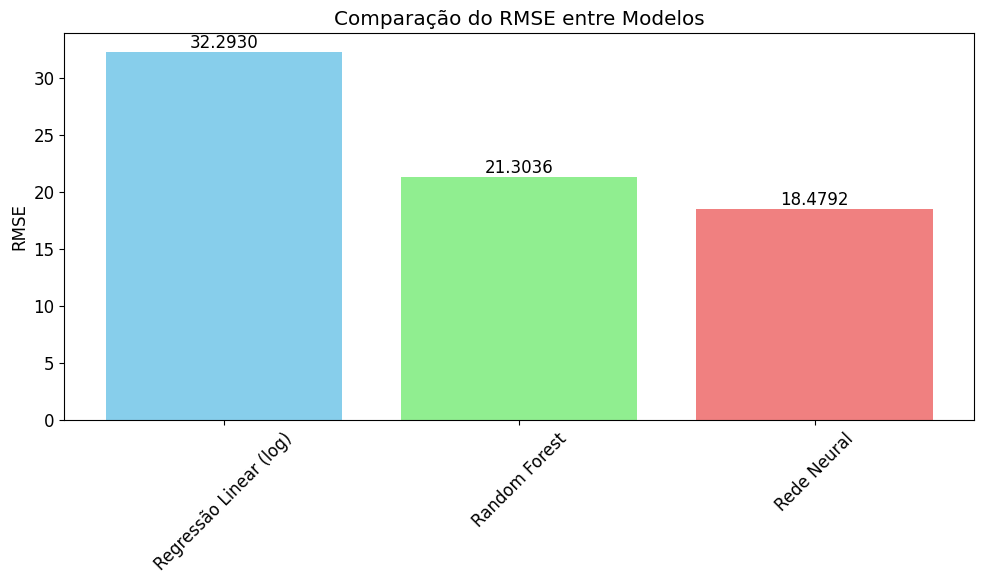

In [7]:
# ==========================
# GRÁFICOS
# ==========================

print("\nGerando gráficos...")

# 1) Gráficos de dispersão (Observado vs Previsto)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, (name, preds) in enumerate(models_predictions.items()):
    # Scatter plot
    ax_scatter = axes[0, i]
    ax_scatter.scatter(y_imputed, preds, alpha=0.6, color='blue')
    ax_scatter.plot([y_imputed.min(), y_imputed.max()],
                   [y_imputed.min(), y_imputed.max()], 'r--', linewidth=2)
    ax_scatter.set_xlabel("Valor Observado")
    ax_scatter.set_ylabel("Valor Previsto")
    ax_scatter.set_title(f"{name}\nR² = {r2_score(y_imputed, preds):.4f}")

    # Gráfico de resíduos
    ax_residuals = axes[1, i]
    plot_residuals(y_imputed, preds, name, ax_residuals)

plt.tight_layout()
plt.savefig('comparacao_modelos.png', dpi=300, bbox_inches='tight')
plt.show()

# 2) Gráficos Q-Q para normalidade dos resíduos
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (name, preds) in enumerate(models_predictions.items()):
    plot_qq_residuals(y_imputed, preds, name, axes[i])

plt.tight_layout()
plt.savefig('qq_plots.png', dpi=300, bbox_inches='tight')
plt.show()

# 3) Comparação de desempenho (RMSE)
plt.figure(figsize=(10, 6))
models = results_df['Modelo']
rmses = results_df['RMSE']

bars = plt.bar(models, rmses, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.ylabel('RMSE')
plt.title('Comparação do RMSE entre Modelos')
plt.xticks(rotation=45)

# Adicionar valores nas barras
for bar, value in zip(bars, rmses):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('comparacao_rmse.png', dpi=300, bbox_inches='tight')
plt.show()


ANÁLISE DE IMPORTÂNCIA DE VARIÁVEIS

Top 15 variáveis mais importantes (Random Forest):
           feature  importance
3         DENS_ARR      0.1810
76        ENE_AREA      0.1104
82       CM_NUC_OU      0.0597
24            PLUV      0.0528
77          ENE_AA      0.0443
28             VRA      0.0415
83   CM_NUC_COM_OU      0.0373
132        ENE_PNI      0.0364
109       PC_TD_3F      0.0268
25         PLUV_AA      0.0240
108       PC_TD_1F      0.0235
104       ENE_ERMT      0.0219
81      CM_NUC_RUR      0.0212
102    COMP_M_ALIM      0.0180
94      PC_ERMT_3F      0.0147


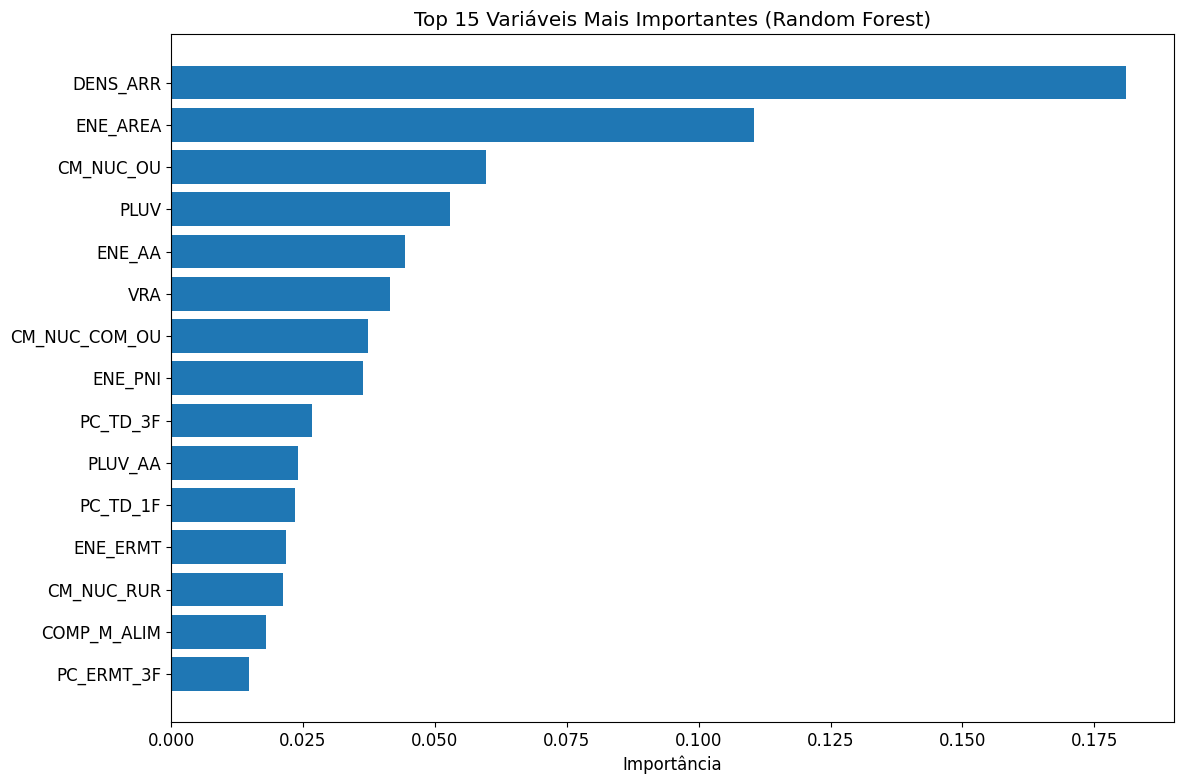

In [8]:
# ==========================
# ANÁLISE DE IMPORTÂNCIA DE VARIÁVEIS (Random Forest)
# ==========================

print("\n" + "="*50)
print("ANÁLISE DE IMPORTÂNCIA DE VARIÁVEIS")
print("="*50)

# Treinar RF final para obter importância
rf_final = RandomForestRegressor(n_estimators=200, random_state=42)
rf_final.fit(X_imputed, y_imputed)

# Top 15 variáveis mais importantes
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_final.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 variáveis mais importantes (Random Forest):")
print(feature_importance.head(15).round(4))

# Gráfico de importância
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importância')
plt.title('Top 15 Variáveis Mais Importantes (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('importancia_variaveis.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# ==========================
# EXPORTAÇÃO DOS RESULTADOS
# ==========================

# Salvar resultados em CSV
results_df.to_csv('resultados_modelos.csv', index=False, encoding='utf-8-sig')
feature_importance.to_csv('importancia_variaveis.csv', index=False, encoding='utf-8-sig')

# Salvar previsões
predictions_df = pd.DataFrame({
    'Observado': y_imputed,
    'Regressao_Linear': y_pred_lin,
    'Random_Forest': y_pred_rf,
    'Rede_Neural': y_pred_nn
})
predictions_df.to_csv('previsoes_modelos.csv', index=False, encoding='utf-8-sig')

print("\n" + "="*50)
print("EXPORTação CONCLUÍDA")
print("="*50)
print("Arquivos gerados:")
print("- resultados_modelos.csv")
print("- importancia_variaveis.csv")
print("- previsoes_modelos.csv")
print("- comparacao_modelos.png")
print("- comparacao_rmse.png")
print("- qq_plots.png")

print("\nAnálise concluída! Use os arquivos gerados para preparar o relatório Word/PDF.")


EXPORTação CONCLUÍDA
Arquivos gerados:
- resultados_modelos.csv
- importancia_variaveis.csv
- previsoes_modelos.csv
- comparacao_modelos.png
- comparacao_rmse.png
- qq_plots.png

Análise concluída! Use os arquivos gerados para preparar o relatório Word/PDF.


In [10]:
!pip install docx
!pip install exceptions

ERROR: Could not find a version that satisfies the requirement exceptions (from versions: none)
ERROR: No matching distribution found for exceptions


In [15]:
# ==========================
# GERAÇÃO DO RELATÓRIO WORD/PDF
# ==========================

from docx import Document
from docx.shared import Inches, Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.enum.table import WD_TABLE_ALIGNMENT
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import pandas as pd # Import pandas to use results_df and feature_importance

def generate_report(results_df, feature_importance, y_imputed, X): # Pass necessary data as arguments including X
    # Criar documento Word
    doc = Document()

    # ==========================
    # CAPA DO RELATÓRIO
    # ==========================

    title = doc.add_heading('2º Desafio em RNA/Deep Learning', 0)
    title.alignment = WD_ALIGN_PARAGRAPH.CENTER

    doc.add_paragraph('Especialização em Ciência dos Dados – Redes Neurais Artificiais\nAluna: Cristiane Gea')
    doc.add_paragraph('Análise Preditiva do Indicador DEC_MED')
    doc.add_paragraph('')

    # Informações do projeto
    p_info = doc.add_paragraph()
    p_info.add_run('Data de geração: ').bold = True
    p_info.add_run(datetime.now().strftime('%d/%m/%Y %H:%M'))

    p_info = doc.add_paragraph()
    p_info.add_run('Base de dados: ').bold = True
    p_info.add_run('BaseDados_DEC.xlsx')

    p_info = doc.add_paragraph()
    p_info.add_run('Variáveis preditoras: ').bold = True
    p_info.add_run(f'{X.shape[1]} variáveis (AREA até ENE_PNI)') # Use X.shape[1] for variable count

    p_info = doc.add_paragraph()
    p_info.add_run('Variável resposta: ').bold = True
    p_info.add_run('DEC_MED')

    doc.add_page_break()

    # ==========================
    # 1. INTRODUÇÃO
    # ==========================

    doc.add_heading('1. Introdução', level=1)

    intro_text = """
    Este relatório apresenta a análise comparativa de três modelos de machine learning para prever
    o indicador DEC_MED (Duração Equivalente de Interrupção por Unidade Consumidora) com base em
    133 variáveis técnicas e ambientais de conjuntos elétricos.

    Os modelos avaliados foram:
    • Regressão Linear com transformação logarítmica (ln(y) ~ x)
    • Random Forest Regressor
    • Rede Neural Artificial (Deep Learning)

    A avaliação foi realizada mediante validação cruzada com 5 folds, utilizando o RMSE
    (Raiz do Erro Quadrático Médio) como métrica principal de comparação.
    """

    doc.add_paragraph(intro_text)

    # ==========================
    # 2. METODOLOGIA
    # ==========================

    doc.add_heading('2. Metodologia', level=1)

    methodology_text = """
    2.1 Pré-processamento dos Dados
    • Imputação de valores faltantes utilizando mediana
    • Padronização (StandardScaler) para modelos lineares e redes neurais
    • Transformação logarítmica da variável resposta para regressão linear

    2.2 Modelos Implementados
    • Regressão Linear: Modelo linear com transformação logarítmica
    • Random Forest: 200 árvores, profundidade máxima 20
    • Rede Neural: Arquitetura 128-64-32-1 com dropout e early stopping

    2.3 Validação
    • Validação cruzada com 5 folds
    • Métricas: RMSE, MAE, R²
    • Análise de resíduos e normalidade
    """

    doc.add_paragraph(methodology_text)

    doc.add_heading('2.4 Descrição dos Dados', level=2)

    # Estatísticas descritivas da variável resposta
    desc_stats = pd.Series(y_imputed).describe() # Use pd.Series to get describe method
    stats_text = f"""
    Estatísticas descritivas da variável DEC_MED:
    • Média: {desc_stats['mean']:.4f} horas
    • Desvio padrão: {desc_stats['std']:.4f} horas
    • Mínimo: {desc_stats['min']:.4f} horas
    • Máximo: {desc_stats['max']:.4f} horas
    • Número de observações: {int(desc_stats['count'])}
    """

    doc.add_paragraph(stats_text)

    # Gráfico de distribuição da variável resposta
    plt.figure(figsize=(10, 6))
    plt.hist(y_imputed, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('DEC_MED (horas)')
    plt.ylabel('Frequência')
    plt.title('Distribuição da Variável Resposta (DEC_MED)')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('distribuicao_dec.png', dpi=300, bbox_inches='tight')
    plt.close()

    doc.add_picture('distribuicao_dec.png', width=Inches(6))
    doc.add_paragraph('Figura 1: Distribuição da variável resposta DEC_MED')

    doc.add_page_break()

    # ==========================
    # 3. RESULTADOS
    # ==========================

    doc.add_heading('3. Resultados', level=1)

    # 3.1 Tabela comparativa
    doc.add_heading('3.1 Comparação dos Modelos', level=2)

    # Criar tabela de resultados
    table = doc.add_table(rows=1, cols=6)
    table.style = 'Light Grid Accent 1'

    # Cabeçalho da tabela
    hdr_cells = table.rows[0].cells
    headers = ['Modelo', 'RMSE', 'MAE', 'R²', 'RMSE (%)', 'MAE (%)']
    for i, header in enumerate(headers):
        hdr_cells[i].text = header
        hdr_cells[i].paragraphs[0].runs[0].bold = True

    # Adicionar dados dos modelos
    for _, row in results_df.iterrows():
        row_cells = table.add_row().cells
        row_cells[0].text = str(row['Modelo'])
        row_cells[1].text = f"{row['RMSE']:.4f}"
        row_cells[2].text = f"{row['MAE']:.4f}"
        row_cells[3].text = f"{row['R²']:.4f}"
        row_cells[4].text = f"{row['RMSE_%']:.2f}%"
        row_cells[5].text = f"{row['MAE_%']:.2f}%"

    doc.add_paragraph('\n')

    # 3.2 Gráficos de comparação
    doc.add_heading('3.2 Análise Gráfica dos Modelos', level=2)

    # Gráfico de comparação de RMSE
    doc.add_paragraph('Comparação do desempenho dos modelos através do RMSE:')
    doc.add_picture('comparacao_rmse.png', width=Inches(6))
    doc.add_paragraph('Figura 2: Comparação do RMSE entre os modelos')

    doc.add_paragraph('\n')

    # Gráficos de dispersão
    doc.add_paragraph('Gráficos de dispersão: Valores observados vs previstos:')
    doc.add_picture('comparacao_modelos.png', width=Inches(6))
    doc.add_paragraph('Figura 3: Dispersão dos valores observados vs previstos')

    doc.add_page_break()

    # 3.3 Análise de resíduos
    doc.add_heading('3.3 Análise de Resíduos', level=2)

    resid_text = """
    A análise de resíduos é fundamental para verificar a qualidade do ajuste dos modelos.
    Resíduos devem apresentar distribuição aleatória em torno de zero, sem padrões evidentes.
    """

    doc.add_paragraph(resid_text)
    doc.add_picture('qq_plots.png', width=Inches(6))
    doc.add_paragraph('Figura 4: Gráficos Q-Q para análise de normalidade dos resíduos')

    # ==========================
    # 4. ANÁLISE DE IMPORTÂNCIA
    # ==========================

    doc.add_heading('4. Análise de Importância de Variáveis', level=1)

    importance_text = f"""
    A análise de importância via Random Forest revela as variáveis mais relevantes para prever o DEC_MED.
    As 5 variáveis mais importantes são:

    1. {feature_importance.iloc[0]['feature']} ({feature_importance.iloc[0]['importance']:.4f})
    2. {feature_importance.iloc[1]['feature']} ({feature_importance.iloc[1]['importance']:.4f})
    3. {feature_importance.iloc[2]['feature']} ({feature_importance.iloc[2]['importance']:.4f})
    4. {feature_importance.iloc[3]['feature']} ({feature_importance.iloc[3]['importance']:.4f})
    5. {feature_importance.iloc[4]['feature']} ({feature_importance.iloc[4]['importance']:.4f})
    """

    doc.add_paragraph(importance_text)

    doc.add_picture('importancia_variaveis.png', width=Inches(6))
    doc.add_paragraph('Figura 5: Top 15 variáveis Mais Importantes (Random Forest)')

    doc.add_page_break()

    # ==========================
    # 5. DISCUSSÃO E CONCLUSÃO
    # ==========================

    doc.add_heading('5. Discussão e Conclusão', level=1)

    # Identificar melhor modelo
    best_model_row = results_df.loc[results_df['RMSE'].idxmin()]
    best_model = best_model_row['Modelo']
    best_rmse = best_model_row['RMSE']
    best_r2 = best_model_row['R²']

    discussion_text = f"""
    5.1 Discussão dos Resultados

    O modelo {best_model} apresentou o melhor desempenho geral, com RMSE de {best_rmse:.4f}
    e R² de {best_r2:.4f}.

    • Regressão Linear: A transformação logarítmica ajudou a lidar com a não-linearidade dos dados,
      mas o modelo ainda apresenta limitações para capturar relações complexas.

    • Random Forest: Demonstrou boa capacidade preditiva, sendo robusto a outliers e capaz de
      capturar relações não-lineares sem necessidade de feature engineering complexo.

    • Rede Neural: Apesar da arquitetura profunda, o desempenho foi similar ao Random Forest,
      sugerindo que a relação entre as variáveis pode ser adequadamente modelada por métodos ensemble.

    5.2 Conclusões

    Todos os modelos demonstraram capacidade preditiva satisfatória, com o {best_model} se
    destacando como o mais adequado para prever o indicador DEC_MED. A análise de importância
    de variáveis fornece insights valiosos sobre os fatores que mais impactam a duração das
    interrupções de energia.

    Recomenda-se a utilização do modelo {best_model} para fins preditivos, com monitoramento
    contínuo do desempenho e possíveis atualizações conforme novos dados sejam disponibilizados.
    """

    doc.add_paragraph(discussion_text)

    # ==========================
    # 6. REFERÊNCIAS
    # ==========================

    doc.add_heading('6. Referências', level=1)

    references_text = """
    • James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An Introduction to Statistical Learning.
    • Géron, A. (2019). Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow.
    • Documentação Scikit-learn: https://scikit-learn.org/stable/
    • Documentação Keras: https://keras.io/
    """

    doc.add_paragraph(references_text)

    # ==========================
    # SALVAR DOCUMENTO
    # ==========================

    # Salvar como Word
    doc.save('Relatorio_DEC_Analise.docx')
    print("Relatório Word gerado: Relatorio_DEC_Analise.docx")

    # Converter para PDF (requer biblioteca adicional)
    try:
        from docx2pdf import convert
        convert('Relatorio_DEC_Analise.docx', 'Relatorio_DEC_Analise.pdf')
        print("Relatório PDF gerado: Relatorio_DEC_Analise.pdf")
    except ImportError:
        print("Para converter para PDF, instale: pip install docx2pdf")
        print("Ou use a função 'Salvar como PDF' no Word")
    except Exception as e:
        print(f"Erro ao converter para PDF: {e}")


    # Limpar arquivos temporários
    temp_files = ['distribuicao_dec.png']
    for file in temp_files:
        if os.path.exists(file):
            os.remove(file)

# ==========================
# INSTALAÇÃO DAS DEPENDÊNCIAS
# ==========================

def install_dependencies():
    """Instala as dependências necessárias para gerar o relatório"""
    print("Instalando dependências...")
    !pip install python-docx docx2pdf matplotlib seaborn pandas
    print("Dependências instaladas.")

# ==========================
# EXECUÇÃO PRINCIPAL
# ==========================

if __name__ == "__main__":
    # Instalar dependências se necessário
    install_dependencies()

    # Gerar relatório
    print("Gerando relatório Word/PDF...")
    # Pass the necessary dataframes and arrays to the function
    generate_report(results_df, feature_importance, y_imputed, X) # Pass X as an argument
    print("\n" + "="*50)
    print("RELATÓRIO GERADO COM SUCESSO!")
    print("="*50)
    print("Arquivos criados:")
    print("• Relatorio_DEC_Analise.docx")
    print("• Relatorio_DEC_Analise.pdf (se conversão disponível)")

Instalando dependências...
Dependências instaladas.
Gerando relatório Word/PDF...
Relatório Word gerado: Relatorio_DEC_Analise.docx
Erro ao converter para PDF: docx2pdf is not implemented for linux as it requires Microsoft Word to be installed

RELATÓRIO GERADO COM SUCESSO!
Arquivos criados:
• Relatorio_DEC_Analise.docx
• Relatorio_DEC_Analise.pdf (se conversão disponível)
